# Data Analysis Take-Home Challenge

### By Logan Larson

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
plt.style.use('seaborn-pastel')

In [2]:
# import data

logins = pd.read_json('logins.json')
df = pd.DataFrame(pd.to_datetime(logins['login_time']), columns=['login_time'])
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


## Part 1: Exploratory Data Analysis

In [3]:
# view dataset
print('Beginning of time series: ', '\n', df.head(), '\n')
print('End of time series: ', '\n', df.tail())

Beginning of time series:  
            login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21 

End of time series:  
                login_time
93137 1970-04-13 18:50:19
93138 1970-04-13 18:43:56
93139 1970-04-13 18:54:02
93140 1970-04-13 18:57:38
93141 1970-04-13 18:54:23


In [4]:
# check for null values in the dataset
nulls = df.isnull().values.any()

if nulls == False:
    print('We are good to go. No null values exist in this dataset.')
else:
    print('Null values exist in this dataset')

We are good to go. No null values exist in this dataset.


In [5]:
# group data by 15 minute intervals
by15 = df.resample('15min', on='login_time').count()
by15.columns = ['freq']
by15

,freq
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [6]:
print('\n', 'Summary Statistics of Grouped Dataset:', '\n')
print(by15.freq.describe())


 Summary Statistics of Grouped Dataset: 

count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
Name: freq, dtype: float64


In [15]:
# calculate total number of logins and average logins per day 
total_logins = len(df)
average_logins_per_day = round(total_logins/(31+28+31+13))
per_15 = round(total_logins / by15.freq.count(), 2)

print('\n', 'There were a total of', total_logins, 'logins from Jan 1 to April 13 of 1970.', '\n')
print('On average, roughly', average_logins_per_day, 'logins occurred per day over this time.', '\n')
print('That equates to roughly', per_15, 'logins every 15 minutes with a maximum of', by15.freq.max(), 'logins within a single 15-minute interval.')


 There were a total of 93142 logins from Jan 1 to April 13 of 1970. 

On average, roughly 904 logins occurred per day over this time. 

That equates to roughly 9.52 logins every 15 minutes with a maximum of 73 logins within a single 15-minute interval.


Text(0.5, 0, '')

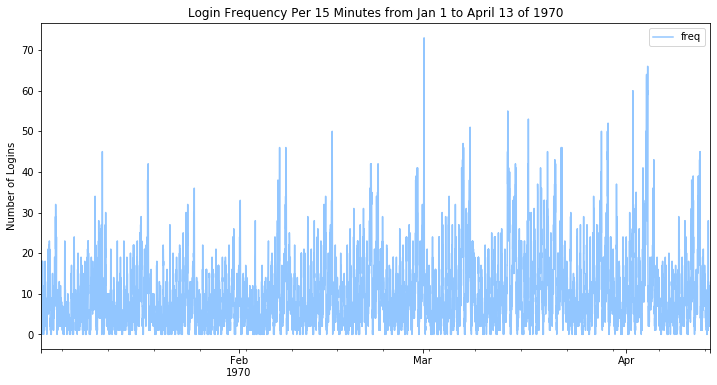

In [16]:
# plot login frequencies over time
by15.plot(kind='line', figsize=(12,6))
plt.title('Login Frequency Per 15 Minutes from Jan 1 to April 13 of 1970')
plt.ylabel('Number of Logins')
plt.xlabel(None)

In [17]:
# create new columns for day of month and day of week
by15 = by15.assign(day_of_week=by15.index.weekday)
by15 = by15.assign(day_of_month=by15.index.day)
by15.head()

,freq,day_of_week,day_of_month
login_time,,,
1970-01-01 20:00:00,2,3,1
1970-01-01 20:15:00,6,3,1
1970-01-01 20:30:00,9,3,1
1970-01-01 20:45:00,7,3,1
1970-01-01 21:00:00,1,3,1


In [22]:
# calculate the days with the most login surges (Monday = 0)
max_traffic = np.quantile(by15, 0.99)
max_traffic_df = by15[by15['freq'] >= max_traffic]
monthday = []
weekday = []

for date in max_traffic_df.index:
    monthday.append(date.day)
    weekday.append(date.weekday())
    
most_active_days_of_week = pd.DataFrame(weekday, columns=['day'],index=range(len(weekday)))
most_active_days_of_month = pd.DataFrame(monthday, columns=['day'],index=range(len(monthday)))

print('Week days with most surges:', '\n', most_active_days_of_week.day.value_counts())
print('\n', 'Days of month with most surges:', '\n', most_active_days_of_month.day.value_counts())

Week days with most surges: 
 5    104
6    103
4     48
3     15
2      7
1      7
0      2
Name: day, dtype: int64

 Days of month with most surges: 
 21    25
4     24
15    18
22    18
28    17
7     15
8     15
29    14
14    14
3     13
12    13
13    11
1     11
18    10
11    10
19     9
6      9
5      8
27     8
17     7
10     4
20     4
2      4
25     2
16     1
24     1
30     1
Name: day, dtype: int64


Considering the fifth day of the week corresponds with Saturday and the sixth with Sunday, it seems the weekends are the busiest time for logins. However, there doesn't appear to be a relationship between traffic and day of the month.

Text(0.5, 0, '')

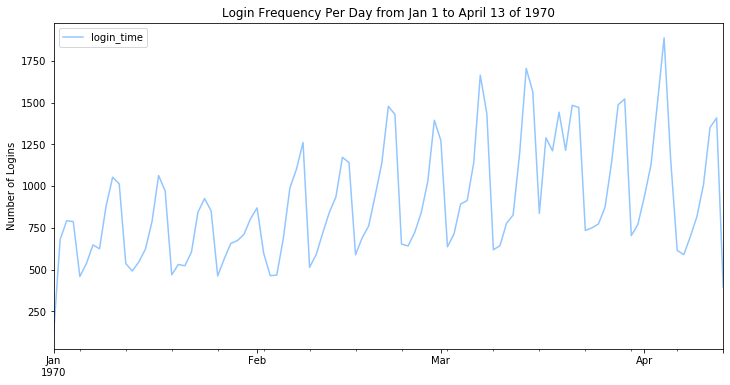

In [25]:
## plot the daily frequency of logins

# regroup by daily frequency
byday = df.resample('1D', on='login_time').count()
byday.plot(kind='line', figsize=(12,6))
plt.title('Login Frequency Per Day from Jan 1 to April 13 of 1970')
plt.ylabel('Number of Logins')
plt.xlabel(None)

In [31]:
# another plot of daily frequencies showing regression line and confidence interval

plotbyday = byday.assign(x = range(byday.shape[0]))
plotbyday.columns = ['count', 'day']
plotbyday

,count,day
login_time,,
1970-01-01,112,0
1970-01-02,681,1
1970-01-03,793,2
1970-01-04,788,3
1970-01-05,459,4
...,...,...
1970-04-09,818,98
1970-04-10,1009,99
1970-04-11,1352,100


Text(0.5, 6.79999999999999, 'Days from January 1')

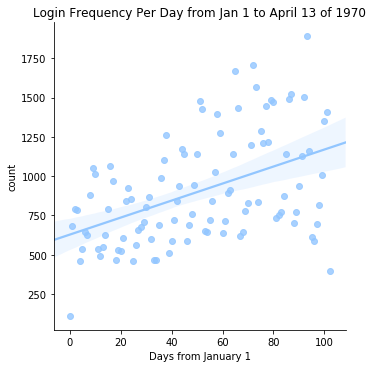

In [32]:
sns.lmplot(data=plotbyday, x='day', y='count')
plt.title('Login Frequency Per Day from Jan 1 to April 13 of 1970')
plt.xlabel('Days from January 1')

## Part 2: Experiment and Metrics Design

### Prompt:

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    - How you will implement the experiment
    - What statistical test(s) you will conduct to verify the significance of the observation
    - How you would interpret the results and provide recommendations to the city operations team along with any caveats

### Answer: 

**Part 1:**

While we know Ultimate wants to encourage drivers to be available in both cities, we aren't told why the company is specifically concerned with drivers being contained to just one of them. But if we think of the combination of the two cities as a single population, the most logical motivation is that Ultimate wants to maximize the total supply of available drivers at any one time. Doing so would not only maximize the amount of rides Ultimate can match with its drivers - and thus maximize profits - but it would also improve overall customer satisfaction, keeping demand and future profits high. 

A good measure of success for this experiment would be a measure thats optimization (or minimization) can tell us whether it's worth continuing the experiment to reimburse toll fees. In other words, we can't just do something like count the number of reimbursed tolls. Even though this could measure whether drivers are crossing the bridge at an increased rate, it doesn't measure either end goal of profits or customer satisfaction/future profits, and thus it would be difficult to tell if its worth it to continue reimbursing the toll costs. It follows that the ideal measure of success would be the proportion of potential riders who logged into the Ultimate app but didn't schedule a ride. More generally, we want the measure to be some form of 'Missed sales'. This is the ideal measure of success because it not only captures the profit component, but the customer satisfaction could be inferred since missed sales presumably corresponds with customer dissatisfaction. Better yet, we could measure the rides that involved the driver first crossing the bridge before picking up the rider as 'Gained Sales', since these kinds of rides apparently wouldn't be happening otherwise. Then, as long as 'Gained Sales' > 'Toll Reimbursement Costs', the experiment would be worth it.

**Part 2:**

My assumption is that Ultimate is a company that operates very similarly to Uber or Lyft. If so, ride-seekers in Gotham and Metropolis would interact with a mobile application by inputting their desired destination and, given their available options, picking an available driver to take them to the destination. Fortunately, this setup makes it relatively simple to design an experiment to test whether it's worth it for Ultimate to pay for toll fees. 

Starting from the first day of testing, Ultimate should log all instances of users who open the mobile app and input a destination. Of this group, we'd then track those who accepted a ride from a driver who was located in the opposite city at the time the user originally requested the ride. If the amount of total sales from these rides exceeds the total amount of reimbursed toll fees, the experiment is worth the cost and is thus practically significant.

To specifically test for statistical significance, we could conduct a Time Series Intervention Analysis. However, we'd first need to collect data from multiple months prior, specifically measuring the users who opened the app and inputted a destination, but did not have a driver available from their city and the user subsequently closed the app. Using the user's original location and destination, we could then estimate the amount of 'Lost Sales' or 'Potential Sales - Lost' from each of these instances. We'd then measure the average amount of sales lost before the experiment and compare it the average amount of sales lost after the start of the experiment.

## Part 3: Predictive Modeling

In [35]:
file = 'ultimate_data_challenge.json'
with open(file) as file:
    data = json.loads(file.read())
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [36]:
len(df)

50000

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [38]:
## clean dataset 

# convert columns of dates to datetime objects
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

# drop rows without a value in phone column
# because it was the only of the three variables 
# with missing values that is categorical
# and we can fill in the other two with mean values
df = df.drop(df[df.phone.isna()==True].index, axis=0)
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(value=df['avg_rating_by_driver'].mean())
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(value=df['avg_rating_of_driver'].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
city                      49604 non-null object
trips_in_first_30_days    49604 non-null int64
signup_date               49604 non-null datetime64[ns]
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
last_trip_date            49604 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 49604 non-null float64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.6+ MB


In [39]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,2.277256,4.601467,1.074991,8.875314,60.883832,5.785418,4.777861
std,3.793300,0.565227,0.222666,19.989018,37.086239,5.669709,0.446220
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.700000,100.000000,6.930000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [40]:
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [41]:
# define variable for retained customers
IndexDay = max(df['last_trip_date'])
days = pd.date_range(end=IndexDay, periods=30, freq='D')
df['user_is_active'] = df['last_trip_date'].apply(lambda date: 0 if (IndexDay-date).days > 30 else 1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,user_is_active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [42]:
percent_active = (df.user_is_active == 1).sum() / len(df)
print(round(percent_active, 3), 'percent of users can be considered "active".')

0.376 percent of users can be considered "active".


Text(0.5, 0, '')

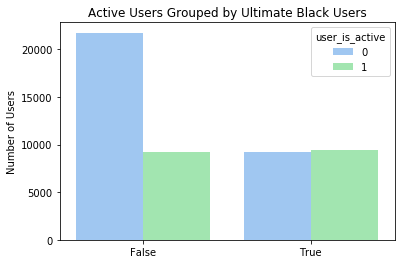

In [43]:
# plot of active users grouped by whether the user is also an Ultimate Black user
sns.countplot(x='ultimate_black_user', hue='user_is_active', data=df)
plt.title('Active Users Grouped by Ultimate Black Users')
plt.ylabel('Number of Users')
plt.xlabel(None)

Text(0.5, 0, '')

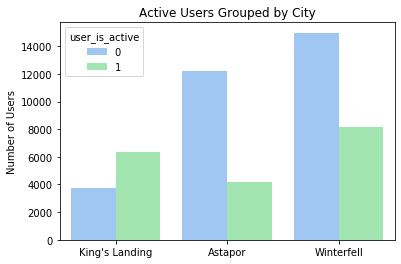

In [44]:
# plot of active users grouped by city
sns.countplot(x='city', hue='user_is_active', data=df)
plt.title('Active Users Grouped by City')
plt.ylabel('Number of Users')
plt.xlabel(None)

Text(0.5, 0, '')

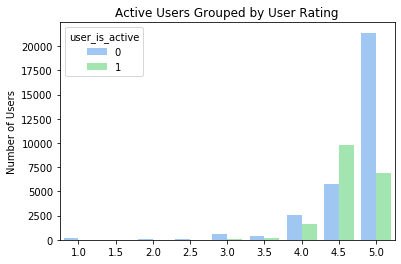

In [45]:
# plot of active users grouped by the average driver rating of the user
df['binned_rating_by_driver'] = df.avg_rating_by_driver.apply(lambda x: 0 if x < 0.5
                                                                  else (0.5 if x < 1
                                                                  else (1 if x < 1.5
                                                                  else (1.5 if x < 2
                                                                  else (2 if x < 2.5
                                                                  else (2.5 if x < 3
                                                                  else (3 if x < 3.5
                                                                  else (3.5 if x < 4
                                                                  else (4 if x < 4.5
                                                                  else (4.5 if x < 5
                                                                  else 5))))))))))
df.head()

# plot of active users by average review
sns.countplot(x='binned_rating_by_driver', hue='user_is_active', data=df)
plt.title('Active Users Grouped by User Rating')
plt.ylabel('Number of Users')
plt.xlabel(None)

Text(0.5, 0, '')

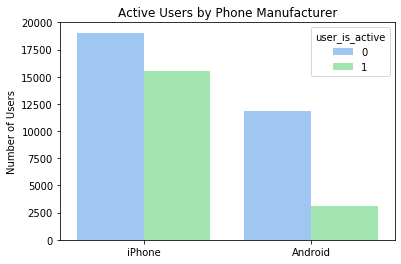

In [46]:
# plot of active users grouped by phone
sns.countplot(x='phone', hue='user_is_active', data=df)
plt.title('Active Users by Phone Manufacturer')
plt.ylabel('Number of Users')
plt.xlabel(None)

In [47]:
df.avg_dist.describe()

count    49604.000000
mean         5.785418
std          5.669709
min          0.000000
25%          2.420000
50%          3.880000
75%          6.930000
max        160.960000
Name: avg_dist, dtype: float64

Text(0.5, 0, '')

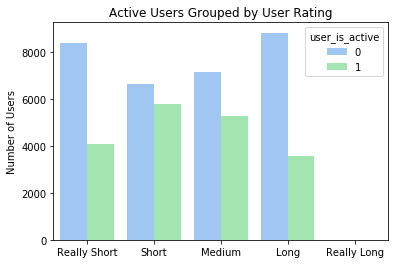

In [48]:
# plot of active users grouped by the average distance
df['binned_avg_dist'] = df.avg_dist.apply(lambda x: 'Really Long' if x > 60
                                          else ('Long' if x > 6.93
                                                else ('Medium' if x > 3.88
                                                      else ('Short' if x > 2.42
                                                            else ('Really Short')))))
df.head()

# plot of active users by average review
sns.countplot(x='binned_avg_dist', hue='user_is_active', order=['Really Short', 'Short', 'Medium', 'Long', 'Really Long'], data=df)
plt.title('Active Users Grouped by User Rating')
plt.ylabel('Number of Users')
plt.xlabel(None)

In [49]:
## time to build predictive model

df_features = pd.get_dummies(df, columns=['city','phone','ultimate_black_user'], drop_first=True)
df_features.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,user_is_active,binned_rating_by_driver,binned_avg_dist,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,5.0,Short,1,0,1,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,5.0,Long,0,0,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,5.0,Really Short,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,4.5,Really Short,1,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,4.5,Short,0,1,0,0


In [54]:
del df_features['last_trip_date']
#del df_features['signup_date']
#del df_features['binned_rating_by_driver']
#del df_features['binned_avg_dist']

In [55]:
df_features.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,user_is_active,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1,1,0,1,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,0,0,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,0,0,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,1,0,1,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,0,0


In [56]:
from sklearn.model_selection import train_test_split
X = np.array(df_features.drop('user_is_active', axis=1))
y = np.array(df_features.user_is_active)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

LR = LogisticRegression().fit(X_train, y_train)
LR_train_pred = LR.predict(X_train)
LR_test_pred = LR.predict(X_test)

print('\n Logistic Regression baseline classifier: \n \n')
print('\n Training Classification Report: \n \n', classification_report(y_train, LR_train_pred, digits = 3, labels=[0,1]))
print('\n Test Classification Report: \n \n', classification_report(y_test, LR_test_pred, digits = 3, labels=[0,1]))


 Logistic Regression baseline classifier: 
 


 Training Classification Report: 
 
               precision    recall  f1-score   support

           0      0.735     0.848     0.788     23179
           1      0.664     0.495     0.567     14024

    accuracy                          0.715     37203
   macro avg      0.700     0.672     0.678     37203
weighted avg      0.708     0.715     0.705     37203


 Test Classification Report: 
 
               precision    recall  f1-score   support

           0      0.741     0.859     0.795      7754
           1      0.679     0.498     0.575      4647

    accuracy                          0.724     12401
   macro avg      0.710     0.678     0.685     12401
weighted avg      0.717     0.724     0.713     12401



//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [63]:
# there isn't much overfitting present, but I'll run a grid search anyway
from sklearn.model_selection import GridSearchCV

param_grid = {'C':np.arange(0.1,1,10)}
#instantiate and fit grid search object
grid = GridSearchCV(LR, param_grid, cv=5)
grid.fit(X_train, np.ravel(y_train))
print('Optimal value of C:', grid.best_estimator_.C)

//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

Optimal value of C: 0.1


In [70]:
#find coefficients from Logistic Regression
LR_tuned= LogisticRegression(C=grid.best_estimator_.C).fit(X_train, y_train)
LR_tuned_train_pred = LR_tuned.predict(X_train)
LR_tuned_test_pred = LR_tuned.predict(X_test)

print('\n Tuned Logistic Regression classifier: \n \n')
print('\n Training Classification Report: \n \n', classification_report(y_train, LR_tuned_train_pred, digits = 3, labels=[0,1]))
print('\n Test Classification Report: \n \n', classification_report(y_test, LR_tuned_test_pred, digits = 3, labels=[0,1]))


 Tuned Logistic Regression classifier: 
 


 Training Classification Report: 
 
               precision    recall  f1-score   support

           0      0.735     0.848     0.788     23179
           1      0.664     0.495     0.568     14024

    accuracy                          0.715     37203
   macro avg      0.700     0.672     0.678     37203
weighted avg      0.709     0.715     0.705     37203


 Test Classification Report: 
 
               precision    recall  f1-score   support

           0      0.741     0.859     0.795      7754
           1      0.679     0.498     0.575      4647

    accuracy                          0.724     12401
   macro avg      0.710     0.679     0.685     12401
weighted avg      0.717     0.724     0.713     12401



//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [72]:
del df_features['user_is_active']
df_coef = pd.DataFrame(zip(list(df_features.columns), LR_tuned.coef_[0]),index=range(df_features.columns.shape[0]), columns=['feature','coefficient'])
df_coef.sort_values(by='coefficient', ascending=False)

,feature,coefficient
7,city_King's Landing,0.688099
9,phone_iPhone,0.494017
0,trips_in_first_30_days,0.442001
10,ultimate_black_user_True,0.423987
8,city_Winterfell,0.255085
3,surge_pct,0.079523
4,weekday_pct,-0.005500
1,avg_rating_of_driver,-0.025597
2,avg_surge,-0.042348
6,avg_rating_by_driver,-0.072844


# Conclusion

Based on the tuned logistic regression model, it appears the features most correlated with retention are living in King's Landing, having an iPhone, taking a trip within the past 30 days, and being an Ultimate Black user. It's possible other classifiers could reach different conclusions, though. Alternatives for such classifiers include a random forest model, a gradient boosting model, or a neural network, among others.

In terms of how Ultimate may leverage these results, I think the company shoulder explore the top two correlated features: city of living and phone manufacturer. It's possible the experience on an Android phone, or something else among Android users, makes Android users less likely to use Ultimate. Maybe its the app. Or, maybe there's a fundamental difference between people who live in King's Landing versus those who live in either of the other two cities.